In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1
!pip3 install 'gast==0.3.3'
import tensorflow as tf

     |████████████████████████████████| 380.5MB 41kB/s 
     |████████████████████████████████| 4.3MB 30.9MB/s 
     |████████████████████████████████| 501kB 42.8MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from scipy.interpolate import splrep, splev

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')
Folder = '/content/drive/My Drive/Colab Notebooks/2021_OEN/'

Mounted at /content/drive


In [ ]:
f_model = keras.models.load_model(Folder + "8L_model_20")
f_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 300)               2700      
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_12 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_13 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_14 (Dense)             (None, 201)               60501     
Total params: 334,101
Trainable params: 334,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X = np.ones((2, 1))
target = 5
t = pd.read_csv(Folder + 'saveT_20.csv').iloc[target]
y = np.array([t, t])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5)
input_shape = [X_train.shape[1]]

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=100,
    restore_best_weights=True,
)

Model Compile Runtime :  4.0
Minimum Train Loss : 0.0319 
 Minimum Validation Loss: 0.0319


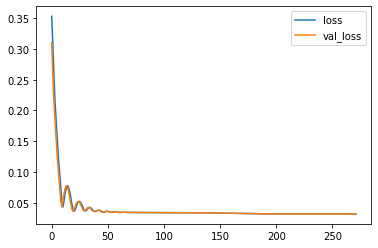

In [ ]:
w_model = model = keras.Sequential([
    layers.Dense(300, activation='relu', input_shape=input_shape),
    layers.Dense(8, activation='relu'),
])

model = keras.Sequential([
    w_model,
    f_model
])
f_model.trainable = False

model.compile(
    optimizer='adam',
    loss='mae',
)

compile_start = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=1,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,
)
compile_end = time.time()
print("Model Compile Runtime : ", np.round(compile_end - compile_start))

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Train Loss : {:0.4f} \n Minimum Validation Loss: {:0.4f}".format(history_df['loss'].min(), history_df['val_loss'].min()))

In [ ]:
# Material Data
Dict_M = ['Air','Ag','Alq3','C60','CuPC','SiO2','SiNx']
OriginData = np.zeros(7, dtype=object)
OriginData[1] = pd.read_csv(Folder + 'Ag.dat', skipinitialspace=True)  # Ag
OriginData[2] = pd.read_csv(Folder + 'Alq3.dat', skipinitialspace=True)  # Alq3
OriginData[3] = pd.read_csv(Folder + 'c60.dat', skipinitialspace=True)  # c60
OriginData[4] = pd.read_csv(Folder + 'cupc.dat', skipinitialspace=True)  # cupc
OriginData[5] = 1.50  # sio2
OriginData[6] = 1.91  # sinx

Points = 200+1
Lambda = np.linspace(400, 800, Points)  # case 1
j = complex(0, 1)

Index = np.zeros((7, 2, Points))
Index[0][0] = np.full(Points, 1.00)
Index[0][1] = np.zeros(Points)
for i in range(1, 5):
    Index[i][0] = np.array(splev(Lambda, splrep(OriginData[i]['lambda'], OriginData[i]['n'])))
    Index[i][1] = np.array(splev(Lambda, splrep(OriginData[i]['lambda'], OriginData[i]['k'])))
Index[5][0] = np.full(Points, 1.50)
Index[5][1] = np.zeros(Points)
Index[6][0] = np.full(Points, 1.91)
Index[6][1] = np.zeros(Points)

Ksquare = np.zeros((7, Points), dtype=complex)
for i in range(7):
    Ksquare[i] = np.ravel(np.square(np.divide(np.ravel(np.transpose(Index[i]) @ np.array([[1], [j]])), Lambda) * 2*np.pi/(10**-9)))

# Layer conditions
Set_M = np.array([5, 6])  # 0~6 : vacuum, ag, alq3, c60, cupc, sio2, sinx
set_num = len(Set_M)
REP = 4
Data_num = 1

def Lm(q, q_next, d):
    Q = np.array([np.array([[(q + q_next) / q_next / 2, (q_next - q) / q_next / 2], [(q_next - q) / q_next / 2, (q + q_next) / q_next / 2]]).swapaxes(0,2), ]*Data_num)
    D = np.multiply(np.eye(2), np.array([np.exp(j * np.outer(q, d).ravel()), np.exp(-j * np.outer(q, d).ravel())]).swapaxes(0, 1)[:, np.newaxis]).reshape(Data_num, Points, 2, 2)
    return Q @ D
vLm = np.vectorize(Lm, otypes=[np.ndarray])

def cal_input(Set_T):
    M = np.array([np.identity(2), ]*Data_num*Points).reshape(Data_num, Points, 2, 2)
    q = np.sqrt(np.array(Ksquare[0]))
    q_next = np.sqrt(np.array(Ksquare[Set_M[0]]))
    M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel([0,]*Data_num)), M)
    q = q_next
    for i in range(1, set_num*REP):
        q_next = np.sqrt(np.array(Ksquare[Set_M[i % set_num]]))
        M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel(Set_T.transpose()[i-1]*(10**-9))), M)
        q = q_next
    q_next = np.sqrt(np.array(Ksquare[0]))
    M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel(Set_T.transpose()[set_num*REP-1]*(10**-9))), M)
    M = np.reshape(M, (Data_num*Points, 4)).transpose()
    r, t = -M[2]/M[3], M[0]-M[1]*M[2]/M[3]
    R, T = np.reshape(abs(r)**2, (Points, Data_num)).transpose(), np.reshape(abs(t)**2, (Points, Data_num)).transpose()
    T = np.round(T, 4)
    return T

Predicted Layer :  [[ 40.  71. 110.  40.  40.  40.  70.  94.]]
Desired Layer :  [113. 165.  90.  97.  63.  86. 150.  98.]


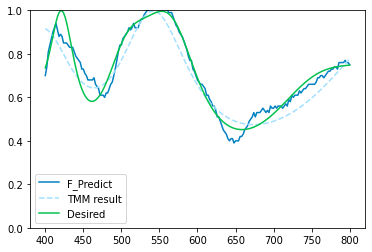

In [ ]:
predict = model.predict([1])
layer_pred = w_model.predict([1])
predict2 = f_model.predict(layer_pred)
tmm_spec = cal_input(layer_pred*160+40)
f_model_20 = keras.models.load_model(Folder + "8L_model_20")
predict3 = f_model_20.predict(layer_pred)

print('Predicted Layer : ', np.round(layer_pred*160+40))
Lambda = np.linspace(400, 800, 201)
#plt.plot(Lambda, predict.reshape(201,), label='Predict')
plt.plot(Lambda, np.round(predict3.reshape(201,), 2), label='F_Predict', c='#0281c2')
plt.plot(Lambda, tmm_spec.reshape(201,), label='TMM result', ls='--', c='#a3e0ff')
plt.plot(Lambda, t, label='Desired', c='#02c24f')
plt.ylim(0.0, 1.0)
plt.legend()

print('Desired Layer : ', np.array(pd.read_csv(Folder + 'saveL_20.csv').iloc[target]))